# **Giới thiệu**

Trong bài này, chúng ta sẽ xây dựng một **pipeline học máy hoàn chỉnh** cho bài toán **phân loại môn học của câu hỏi**.  
Pipeline sẽ bao gồm các bước chính:

1. **EDA (Exploratory Data Analysis):** Khám phá dữ liệu, phân phối nhãn, thống kê văn bản, kiểm tra duplicate và outlier.  
2. **Tiền xử lý dữ liệu (Data Preprocessing):** Làm sạch văn bản, loại bỏ stopwords, chuẩn hóa text, split train-test.  
3. **Trích xuất & lựa chọn đặc trưng (Feature Extraction & Selection):** Áp dụng các kỹ thuật truyền thống (BoW, TF-IDF, n-gram) và embeddings hiện đại (GloVe, DistilBERT).  
4. **Huấn luyện mô hình (Model Training):** Logistic Regression, SVM, Naive Bayes, Random Forest, Decision Tree,…  
5. **Đánh giá kết quả (Evaluation):** Sử dụng các chỉ số Accuracy, Precision, Recall, F1-score, trực quan hóa Confusion Matrix, và so sánh hiệu quả các mô hình.  
6. **End-to-End Deep Learning:** Huấn luyện mạng RNN/LSTM để dự đoán Subject, so sánh với các phương pháp ML + feature extraction.

## **Bộ dữ liệu sử dụng**

- Dataset: [IITJEE / NEET / AIIMS Students Questions Dataset](https://www.kaggle.com/datasets/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data)  
- Nội dung: Câu hỏi của học sinh chuẩn bị cho các kỳ thi cạnh tranh ở Ấn Độ.  
- Cột chính: `eng` (nội dung câu hỏi), `Subject` (nhãn môn học - Physics, Chemistry, Biology, Mathematics).

## **Mục tiêu của bài tập**

- Xây dựng pipeline ML truyền thống với  kỹ thuật trích xuất đặc trưng kết hợp cả truyền thống (BoW, TF-IDF, n-gram) và hiện đại (Word2Vec, GloVe, DistilBERT).  
- Huấn luyện các mô hình ML khác nhau và đánh giá hiệu quả bằng các chỉ số tiêu chuẩn.  
- Triển khai mô hình **end-to-end Deep Learning** (LSTM).
- So sánh hiệu quả giữa các phương pháp truyền thống và deep learning, rút ra nhận xét về ưu nhược điểm của từng phương pháp.

Toàn bộ nội dung cùng các bài Assignment khác trong môn **Machine Learning – HK251** được tổng hợp tại:  
- [Trang tổng hợp Machine Learning – Nhóm DNA05](https://nhinguyen140809.github.io/ml-asm-dna05/)  

Phần tiếp theo sẽ cài đặt và import các thư viện cần thiết để bắt đầu xây dựng pipeline.


# **Cài đặt và Import Thư viện**

Trong bước này, chúng ta sẽ:

- Cài đặt các thư viện cần thiết cho pipeline học máy.

- Import đầy đủ các module phục vụ cho EDA, tiền xử lý, trích xuất đặc trưng, huấn luyện và đánh giá mô hình.

- Thiết lập một số cấu hình cơ bản (ví dụ: tải stopwords, chuẩn bị module riêng của nhóm).

- Lưu ý:

  - Người dùng có thể thêm/bớt thư viện nếu mở rộng pipeline (ví dụ: `deep learning`).

  - Nếu notebook đã có sẵn môi trường, có thể bỏ qua lệnh `!pip install`.

In [ ]:
# ============================================================
# Cài đặt thư viện cần thiết (chỉ chạy lần đầu trên Colab)
# ============================================================
!pip install -q pandas matplotlib seaborn scikit-learn torch transformers wordcloud textacy nltk kagglehub

# ============================================================
# Import các thư viện cơ bản
# ============================================================
import os
import re
import string
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ============================================================
# NLP & Text processing
# ============================================================
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import textacy
import textacy.preprocessing as tprep

# ============================================================
# Deep Learning (tùy chọn)
# ============================================================
import torch
from transformers import AutoTokenizer, AutoModel

# ============================================================
# Clone repo GitHub của nhóm và chuẩn bị module riêng
# ============================================================
#!rm -rf ml-asm-dna05                                               # Xoá repo cũ (Colab)
#!git clone -q https://github.com/nhinguyen140809/ml-asm-dna05.git  # Clone repo mới

# Thêm đường dẫn module vào sys.path
#sys.path.append("ml-asm-dna05/modules")                            # Colab
sys.path.append("../modules")                                       # Local

# Import pipeline helper
from ml_pipeline import download_kaggle_dataset

print("✅ Import và cài đặt thư viện thành công, repo GitHub đã được clone!")

# ============================================================
# Cài đặt các tuỳ chọn mặc định
# ============================================================
LOAD_PREPROCESSED = True
LOAD_FEATURE = True
LOAD_PRETRAINED = True

# ============================================================
# Cài đặt gdown nếu chưa có
# ============================================================
!pip install -q gdown
import os
import gdown

# ============================================================
# Thư mục lưu trên Colab
# ============================================================
FEATURE_DIR = "/content/ml-asm-dna05/features/BTL2"
os.makedirs(FEATURE_DIR, exist_ok=True)

# ============================================================
# 1. Tải toàn bộ folder từ Google Drive
# ============================================================
folder_url = "https://drive.google.com/drive/u/2/folders/1SDTK_U0yrAkNcu7KVR9fvB0yezl4m5Hs"
gdown.download_folder(folder_url, output=FEATURE_DIR + "/LSTM", quiet=False, use_cookies=False)

# ============================================================
# 2. Tải riêng file DistilBERT
# ============================================================
file_url = "https://drive.google.com/uc?id=196lFv4_ejQNaA6DtqBnNz8X5MK17M0no"
output_file = os.path.join(FEATURE_DIR, "X_train_distilbert.h5")
gdown.download(file_url, output=output_file, quiet=False)

print("\n✅ Tải xong toàn bộ file cần thiết", FEATURE_DIR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.6/321.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 102.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Import và cài đặt thư viện thành công, repo GitHub đã được clone!


Retrieving folder contents


Processing file 1PCR9TPIC1vKmDlo9Xy2H91qee_p4ZT-E config.json
Processing file 1Bv3F8gvJZ83EeQkldWANLzHznJXq9jcF metrics.csv
Processing file 1y1XKhAbJEWh2japdFks9onVXoGDY83i9 model_lstm.pth
Processing file 1ge4bH_KiMozpgAjrhOashTLC7l5ga47u optimizer_lstm.pth


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1PCR9TPIC1vKmDlo9Xy2H91qee_p4ZT-E
To: /content/ml-asm-dna05/features/BTL2/LSTM/config.json
100%|██████████| 196/196 [00:00<00:00, 780kB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bv3F8gvJZ83EeQkldWANLzHznJXq9jcF
To: /content/ml-asm-dna05/features/BTL2/LSTM/metrics.csv
100%|██████████| 338/338 [00:00<00:00, 1.42MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1y1XKhAbJEWh2japdFks9onVXoGDY83i9
From (redirected): https://drive.google.com/uc?id=1y1XKhAbJEWh2japdFks9onVXoGDY83i9&confirm=t&uuid=7715b49e-6782-4c9f-ad94-a0fe838abce2
To: /content/ml-asm-dna05/features/BTL2/LSTM/model_lstm.pth
100%|██████████| 30.2M/30.2M [00:00<00:00, 52.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ge4bH_KiMozpgAjrhOashTLC7l5ga47u
From (redirected): https://drive.google.com/uc?id=1ge4bH_KiMozpgAjrhO


✅ Tải xong toàn bộ file cần thiết /content/ml-asm-dna05/features/BTL2


# **Tải Dataset**

Trong bước này, chúng ta sẽ:

- Tải **IITJEE / NEET / AIIMS Students Questions Dataset** từ Kaggle thông qua module `kagglehub`.
- Thiết lập cách xử lý giá trị thiếu (`na_values`) để dữ liệu được chuẩn hóa ngay từ đầu.

Cấu hình có thể thay đổi:

- `DATASET_NAME`: Tên dataset trên Kaggle (có thể đổi sang dataset khác).
- `FILE_EXTENSION`: Phần mở rộng của file dữ liệu cần đọc (mặc định `.csv`).
- `NA_VALUES`: Các giá trị coi là missing (có thể thêm `"NA"`, `"?"` nếu dataset khác).

In [ ]:
# ============================================================
# Cấu hình tải dataset
# ============================================================
CONFIG = {
    "DATASET_NAME": "mrutyunjaybiswal/iitjee-neet-aims-students-questions-data",  # Thay đổi nếu muốn dùng dataset khác
    "FILE_EXTENSION": ".csv",                                                     # Có thể đổi sang .xlsx nếu cần
    "NA_VALUES": ["", np.nan]                                                     # Các giá trị coi là missing
}

# ============================================================
# Đọc dữ liệu vào DataFrame
# ============================================================
csv_path = download_kaggle_dataset(CONFIG["DATASET_NAME"], CONFIG["FILE_EXTENSION"])

df = pd.read_csv(
    csv_path,
    keep_default_na=False,
    na_values=CONFIG["NA_VALUES"]
)

print("Dataset loaded thành công!")
display(df.head())


Using Colab cache for faster access to the 'iitjee-neet-aims-students-questions-data' dataset.
Dataset downloaded to: /kaggle/input/iitjee-neet-aims-students-questions-data
Dataset loaded thành công!


,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


# **1. EDA – Exploratory Data Analysis**

Trong bước này, chúng ta sẽ khám phá dataset để hiểu rõ **cấu trúc, phân phối nhãn, và đặc điểm văn bản**.  
EDA giúp phát hiện **vấn đề dữ liệu**, như missing values, duplicate, hoặc outlier, trước khi tiền xử lý và huấn luyện mô hình.



## 1.1. Kiểm tra thông tin cơ bản của dataset


In [ ]:
# Kích thước dataset
print("Số dòng, số cột:", df.shape)

In [ ]:
# Thông tin kiểu dữ liệu
df.info()

In [ ]:
# Kiểm tra missing values
print("\nMissing values từng cột:")
print(df.isnull().sum())

## 1.2. Khám phá nhãn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Phân phối số lượng câu hỏi theo Subject
sns.countplot(x='Subject', data=df)
plt.title("Phân phối số lượng câu hỏi theo Subject")
plt.show()

In [ ]:
# Tỷ lệ phần trăm từng nhãn
print(df['Subject'].value_counts(normalize=True) * 100)

## 1.3. Thống kê văn bản

In [ ]:
# ============================================================
# Độ dài văn bản (số ký tự) và số từ
# ============================================================
df['char_count'] = df['eng'].apply(len)
df['word_count'] = df['eng'].apply(lambda x: len(x.split()))

# Tạo figure với 2 subplot: histogram + boxplot
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1])  # 2 hàng, histogram cao hơn boxplot

# Histogram
ax0 = plt.subplot(gs[0])
sns.histplot(df['word_count'], bins=50, kde=False, color='skyblue', ax=ax0)
ax0.set_title("Histogram số từ trong câu hỏi")
ax0.set_xlabel("Số từ")
ax0.set_ylabel("Số câu hỏi")

# Boxplot
ax1 = plt.subplot(gs[1])
sns.boxplot(x=df['word_count'], color='lightgreen', ax=ax1)
ax1.set_xlabel("Số từ (có outlier)")
ax1.set_yticks([])  # ẩn trục y

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Thống kê nhanh outlier
# ============================================================
q1 = df['word_count'].quantile(0.25)
q3 = df['word_count'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr

outliers = df[(df['word_count'] < lower_bound) | (df['word_count'] > upper_bound)]
print(f"Số câu hỏi là outlier: {outliers.shape[0]}")
display(outliers.head())

In [ ]:
# ============================================================
# Thống kê câu quá ngắn / quá dài
# ============================================================
short_threshold = 3
long_threshold = 200

num_short = (df['word_count'] < short_threshold).sum()
num_long = (df['word_count'] > long_threshold).sum()
print(f"Số câu quá ngắn (<{short_threshold} từ): {num_short}")
print(f"Số câu quá dài (>{long_threshold} từ): {num_long}")

# In ra vài câu quá ngắn
short_sentences = df[df['word_count'] < short_threshold]['eng']
print("\nVí dụ các câu quá ngắn:")
print(short_sentences.head(10))  # in tối đa 10 câu

# In ra vài câu quá dài
long_sentences = df[df['word_count'] > long_threshold]['eng']
print("\nVí dụ các câu quá dài:")
print(long_sentences.head(5))  # in tối đa 5 câu

In [ ]:
# -------------------------------
# Độ dài ký tự
# -------------------------------

plt.figure(figsize=(10,5))
sns.boxplot(x='Subject', y='char_count', data=df)
plt.title("Boxplot độ dài ký tự theo Subject")
plt.show()


In [ ]:
# ============================================================
# Vocabulary size theo lớp
# ============================================================
def get_vocab(text_series):
    words = []
    for t in text_series:
        t_clean = re.sub(f"[{string.punctuation}]", "", t.lower())
        words.extend(t_clean.split())
    return set(words)

for subject in df['Subject'].unique():
    vocab = get_vocab(df[df['Subject']==subject]['eng'])
    print(f"Subject: {subject}, vocabulary size: {len(vocab)}")

In [ ]:
# ============================================================
# WordCloud tổng thể & từng Subject
# ============================================================

from wordcloud import WordCloud

# -------------------------------
# WordCloud tổng thể
# -------------------------------
all_text = " ".join(df['eng'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud tổng thể")
plt.show()

# -------------------------------
# WordCloud theo từng Subject
# -------------------------------
subjects = df['Subject'].unique()

for subject in subjects:
    subject_text = " ".join(df[df['Subject']==subject]['eng'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(subject_text)

    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Subject: {subject}")
    plt.show()


## 1.4. Kiểm tra các giá trị trùng lặp

In [ ]:
duplicates = df[df.duplicated(subset=['eng'], keep=False)]  # keep=False để lấy tất cả bản duplicate

print(f"Tổng số câu hỏi trùng lặp: {duplicates.shape[0]}")

# Nhóm theo text để xem có bao nhiêu bản duplicate và các môn liên quan
duplicate_groups = (
    duplicates.groupby('eng')
    .agg(
        count=('Subject', 'count'),
        subjects=('Subject', lambda x: ', '.join(sorted(set(x))))
    )
    .reset_index()
    .sort_values(by='count', ascending=False)
)

# In ra 5 câu hỏi trùng lặp nhiều nhất (kèm danh sách Subject)
print("5 câu hỏi trùng lặp nhiều nhất:")
display(duplicate_groups.head(5))

# **2. Tiền xử lý dữ liệu**

Trong bước này, chúng ta sẽ thực hiện **làm sạch dữ liệu** trước khi tiến hành trích xuất đặc trưng:
- Loại bỏ các câu **duplicate** gây nhiễu.
- Chuẩn hóa văn bản.
- Tạo hai phiên bản dữ liệu: **ML-ready** (lowercase + remove stopwords) và **DL-ready** (giữ nguyên case + giữ stopwords).


## 2.0. [Tuỳ chọn] Load dữ liệu đã được tiền xử lý

Bạn có thể chọn **load dữ liệu train/test đã được làm sạch và xử lý sẵn**, giúp bỏ qua các bước duplicate removal và preprocessing.

Các phiên bản dữ liệu:
- **`v1 – ML-ready`**: duplicate removal và preprocessing bằng `tprep`, kết hợp lowercase + remove stopwords, dùng cho ML models (BoW, TF-IDF,…)
- **`v2 – DL-ready`**: duplicate removal và preprocessing bằng `tprep` nhưng giữ nguyên case + stopwords, dùng cho DL models (LSTM, Transformers,…)
## ⚠️ Lưu ý
Tùy chọn: bật/tắt chế độ load sẵn thông qua biến `LOAD_PREPROCESSED`.
Mặc định: `LOAD_PREPROCESSED = True`.

In [ ]:
import os
import numpy as np

LOAD_PREPROCESSED = True              # False nếu muốn chạy thủ công từng ô tiền xử lý

# Thư mục chứa các file đã lưu
FEATURE_DIR = "ml-asm-dna05/features/BTL2"
os.makedirs(FEATURE_DIR, exist_ok=True)

# ---------- Tùy chọn phiên bản muốn load ----------
version = "v1"  # "v1" cho ML-ready, "v2" cho DL-ready

if LOAD_PREPROCESSED:
  if version == "v1":
      X_train = np.load(os.path.join(FEATURE_DIR, "X_train_v1.npy"), allow_pickle=True)
      X_test  = np.load(os.path.join(FEATURE_DIR, "X_test_v1.npy"), allow_pickle=True)
  elif version == "v2":
      X_train = np.load(os.path.join(FEATURE_DIR, "X_train_v2.npy"), allow_pickle=True)
      X_test  = np.load(os.path.join(FEATURE_DIR, "X_test_v2.npy"), allow_pickle=True)
  else:
      raise ValueError("Chỉ chấp nhận version 'v1' hoặc 'v2'!")

  # Load nhãn (y_train, y_test) – dùng chung cho cả 2 phiên bản
  y_train = np.load(os.path.join(FEATURE_DIR, "y_train.npy"), allow_pickle=True)
  y_test  = np.load(os.path.join(FEATURE_DIR, "y_test.npy"), allow_pickle=True)

  print(f"✅ Load xong dữ liệu phiên bản {version}")
  print("Shapes:")
  print("X_train:", X_train.shape, "X_test:", X_test.shape)
  print("y_train:", y_train.shape, "y_test:", y_test.shape)

✅ Load xong dữ liệu phiên bản v1
Shapes:
X_train: (96753,) X_test: (24189,)
y_train: (96753,) y_test: (24189,)


## 2.1. Loại bỏ Duplicate

Các câu hỏi trùng lặp thường là những câu **quá ngắn, chung chung**, ví dụ: `"Match the following"`, và không cung cấp thông tin hữu ích cho việc huấn luyện mô hình.  
Do đó, chúng ta sẽ **xác định và loại bỏ các câu duplicate**.

**Cấu hình có thể thay đổi:**  
- `subset`: cột để kiểm tra duplicate (`'eng'` trong trường hợp này).  
- `keep`: cách giữ lại duplicate (`first`, `last`, `False` để loại bỏ tất cả).  


In [ ]:
if not LOAD_PREPROCESSED:
  # ============================================================
  # Kiểm tra và loại bỏ duplicate
  # ============================================================

  # Kiểm tra duplicate theo cột 'eng' (câu hỏi)
  duplicates = df[df.duplicated(subset=['eng'],
                                keep=False)]
  print(f"Số câu duplicate: {len(duplicates)}")

  # Hiển thị một vài duplicate để tham khảo
  display(duplicates.head(10))

  # Loại bỏ hoàn toàn các duplicate
  df = df.drop_duplicates(subset=['eng'], keep=False)
  print(f"Số câu sau khi loại bỏ duplicate: {len(df)}")

## 2.2. Tiền xử lý dữ liệu & Split Train-Test

Trong bước này, chúng ta thực hiện các công việc:

1. **Pipeline tiền xử lý văn bản**:
   - Thay newline bằng space.
   - Loại bỏ punctuation.
   - Chuẩn hóa từ nối, bullet points, quotation marks.
   - Chuẩn hóa whitespace.

2. **Tạo hai phiên bản văn bản**:
   - `v1`: ML-ready (lowercase + loại stopwords)
   - `v2`: DL-ready (giữ nguyên case, giữ stopwords)

3. **Encode nhãn**:
   - Sử dụng `LabelEncoder` để encode cột `Subject`.

4. **Split train-test**:
   - Giữ stratify theo nhãn để cân bằng phân phối.
   - `test_size=0.2`, `random_state=42`.

5. **Hiển thị sample dữ liệu**:
   - In 5 câu đầu của train set cho cả pipeline ML và DL.

**Cấu hình có thể thay đổi**:
- Stopwords, lowercase, stemming/lemmatization.
- Tỷ lệ train-test, random_state.


In [ ]:
if not LOAD_PREPROCESSED:
  import re
  import textacy
  import textacy.preprocessing as tprep
  from tqdm.notebook import tqdm
  from nltk.corpus import stopwords
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import LabelEncoder
  import numpy as np

  tqdm.pandas()
  stop_words = set(stopwords.words('english'))

  # ---------- Pipeline cơ bản ----------
  clean_pipeline = tprep.make_pipeline(
      lambda text: re.sub(r"\n", " ", text),        # thay newline bằng space
      tprep.remove.punctuation,                     # loại bỏ punctuation
      tprep.normalize.hyphenated_words,             # chuẩn hóa từ nối
      tprep.normalize.bullet_points,                # chuẩn hóa bullet points
      tprep.normalize.quotation_marks,              # chuẩn hóa quotation marks
      tprep.normalize.whitespace                    # chuẩn hóa whitespace
  )

  # ---------- Áp dụng pipeline ----------
  df['text_cleaned'] = df['eng'].progress_apply(clean_pipeline)

  # ---------- Tạo 2 phiên bản ----------
  # v1: ML-ready
  df['text_v1'] = df['text_cleaned'].progress_apply(
      lambda x: " ".join([w for w in x.lower().split() if w not in stop_words])
  )

  # v2: DL-ready
  df['text_v2'] = df['text_cleaned'].copy()

  # ---------- Encode labels ----------
  le = LabelEncoder()
  y = le.fit_transform(df['Subject'])
else:
  print("⚠️ Đã load dữ liệu tiền xử lý !")

In [ ]:
if not LOAD_PREPROCESSED:
  # ---------- Split train-test ----------
  X_train_v1, X_test_v1, y_train, y_test = train_test_split(
      df['text_v1'], y, stratify=y, test_size=0.2, random_state=42
  )
  X_train_v2, X_test_v2, _, _ = train_test_split(
      df['text_v2'], y, stratify=y, test_size=0.2, random_state=42
  )

  print("Train size:", len(X_train_v1))
  print("Test size:", len(X_test_v1))

  print("=" * 40)
  print("Sample train set for pipeline ML")
  for i, (q, s) in enumerate(zip(X_train_v1.head(5), y_train[:5]), 1):
      decoded_label = le.inverse_transform([s])[0]
      print(f"{i}. [{decoded_label}] {q}")

  print("=" * 40)
  print("Sample train set for pipeline DL")
  for i, (q, s) in enumerate(zip(X_train_v2.head(5), y_train[:5]), 1):
      decoded_label = le.inverse_transform([s])[0]
      print(f"{i}. [{decoded_label}] {q}")
else:
  print("⚠️ Đã load dữ liệu tiền xử lý !")

In [ ]:
if not LOAD_PREPROCESSED:
  # ---------- Lưu file để sử dụng sau ----------
  # Đường dẫn thư mục đã clone
  FEATURE_DIR = "ml-asm-dna05/features/BTL2/"

  # Lưu các file train/test
  np.save(FEATURE_DIR + "X_train_v1.npy", X_train_v1.values)
  np.save(FEATURE_DIR + "X_test_v1.npy", X_test_v1.values)
  np.save(FEATURE_DIR + "X_train_v2.npy", X_train_v2.values)
  np.save(FEATURE_DIR + "X_test_v2.npy", X_test_v2.values)
  np.save(FEATURE_DIR + "y_train.npy", y_train)
  np.save(FEATURE_DIR + "y_test.npy", y_test)

  print("Đã lưu xong tất cả các file X_train/test + y_train/test vào features/BTL2/")

  # Chọn version mặc định để load tiếp cho phần 3
  if version == "v1":
      X_train, X_test = X_train_v1.values, X_test_v1.values
  else:
      X_train, X_test = X_train_v2.values, X_test_v2.values

  print("Shapes:")
  print("X_train:", X_train.shape, "X_test:", X_test.shape)
  print("y_train:", y_train.shape, "y_test:", y_test.shape)
else:
  print("⚠️ Đã load dữ liệu tiền xử lý !")


# **3. Trích xuất đặc trưng**

Trong bước này, ta sẽ tạo các feature từ dữ liệu văn bản:

- BoW, TF-IDF, N-gram  
- Word2Vec / GloVe  
- DistilBERT embeddings  

### ⚠️ Lưu ý

Tất cả các feature đã có sẵn trong thư mục `features/BTL2/`.  

Chúng ta sẽ thêm biến **`LOAD_FEATURE = True/False`**:
- `True`: load trực tiếp feature từ file `.h5` hoặc `.npy`.
- `False`: rebuild feature từ dữ liệu train/test (chạy pipeline trích xuất lại).

Mặc định: `LOAD_FEATURE = True`

In [ ]:
LOAD_FEATURE = True # False nếu muốn trích xuất đặc trưng lại từng phương pháp

## 3.1. Traditional Methods

Trong các phương pháp **Truyền thống** (BoW, TF-IDF, N-gram…), feature thường là **sparse matrix**.  
Chúng ta cần các hàm tiện ích để:

- **Lưu** sparse matrix sang file `.h5`.
- **Load** lại sparse matrix từ file `.h5` khi cần.

In [ ]:
if not LOAD_FEATURE:
  import h5py
  import scipy.sparse as sp
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  import joblib
  from tqdm import tqdm

  FEATURE_DIR = "ml-asm-dna05/features/BTL2/"

  def save_sparse_h5(filename, matrix):
      """
      Lưu sparse matrix (.csr) sang file .h5
      Args:
          filename (str): Đường dẫn file .h5
          matrix (scipy.sparse.csr_matrix): Sparse matrix cần lưu
      """
      with h5py.File(filename, 'w') as f:
          f.create_dataset('data', data=matrix.data)
          f.create_dataset('indices', data=matrix.indices)
          f.create_dataset('indptr', data=matrix.indptr)
          f.create_dataset('shape', data=matrix.shape)
      print(f"✅ Lưu sparse matrix thành công: {filename}")

  def load_sparse_h5(filename):
      """
      Đọc lại sparse matrix từ file .h5
      Args:
          filename (str): Đường dẫn file .h5
      Returns:
          scipy.sparse.csr_matrix
      """
      with h5py.File(filename, 'r') as f:
          data = f['data'][:]
          indices = f['indices'][:]
          indptr = f['indptr'][:]
          shape = tuple(f['shape'][:])
      return sp.csr_matrix((data, indices, indptr), shape=shape)
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

**Ghi chú:**

- Dùng `save_sparse_h5()` khi trích xuất xong BoW / TF-IDF để lưu feature.  
- Dùng `load_sparse_h5()` khi muốn load lại feature đã lưu, **không cần rebuild**.  
- Giúp tiết kiệm thời gian, đặc biệt với dataset lớn.

## 3.1.1. Bag-of-Words (BoW)

BoW là một trong những phương pháp **truyền thống** để biểu diễn văn bản:

- Mỗi câu được biểu diễn bằng **vector đếm từ**.
- Có thể giới hạn số từ tối đa (`max_features`) và lựa chọn n-gram (`ngram_range`).

In [ ]:
if not LOAD_FEATURE:
  # ============================================================
  # 🧱 Bag-of-Words (BoW)
  # ============================================================

  print("\n=== Generating Bag-of-Words features ===")

  # Khởi tạo BoW vectorizer
  # max_features: số từ tối đa
  # ngram_range: (1,1) nghĩa là unigram
  bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,1))

  # Fit trên tập train và transform cả train/test
  X_train_bow = bow_vectorizer.fit_transform(X_train)
  X_test_bow  = bow_vectorizer.transform(X_test)

  # Lưu sparse matrix và vectorizer để tái sử dụng
  save_sparse_h5(FEATURE_DIR + "X_train_bow.h5", X_train_bow)
  save_sparse_h5(FEATURE_DIR + "X_test_bow.h5", X_test_bow)
  joblib.dump(bow_vectorizer, FEATURE_DIR + "bow_vectorizer.pkl")

  print(f"✅ BoW done! Shapes: X_train={X_train_bow.shape}, X_test={X_test_bow.shape}")
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

**Ghi chú:**

- Sau khi chạy xong, **feature BoW đã được lưu** và có thể load lại bằng `load_sparse_h5()` hoặc vectorizer bằng `joblib.load()`.  
- Nếu đã load sẵn feature từ file `.h5`, **không cần chạy lại** ô code này.

## 3.1.2. TF-IDF

TF-IDF (Term Frequency – Inverse Document Frequency) giúp **làm nổi bật những từ quan trọng** trong tập dữ liệu:

- Giảm trọng số các từ phổ biến (như "the", "and").
- Giữ nguyên dạng sparse matrix để tiết kiệm bộ nhớ.

In [ ]:
if not LOAD_FEATURE:
  # ============================================================
  # 🧮 TF-IDF
  # ============================================================

  print("\n=== Generating TF-IDF features ===")

  # Khởi tạo TF-IDF vectorizer
  tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))

  # Fit trên tập train và transform cả train/test
  X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
  X_test_tfidf  = tfidf_vectorizer.transform(X_test)

  # Lưu sparse matrix và vectorizer để tái sử dụng
  save_sparse_h5(FEATURE_DIR + "X_train_tfidf.h5", X_train_tfidf)
  save_sparse_h5(FEATURE_DIR + "X_test_tfidf.h5", X_test_tfidf)
  joblib.dump(tfidf_vectorizer, FEATURE_DIR + "tfidf_vectorizer.pkl")

  print(f"✅ TF-IDF done! Shapes: X_train={X_train_tfidf.shape}, X_test={X_test_tfidf.shape}")
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

**Ghi chú:**

- Sau khi chạy xong, feature được **lưu sẵn**, có thể load lại bằng `load_sparse_h5()` mà không cần chạy lại pipeline.
- Nếu bạn đã load sẵn feature từ file `.h5`, **có thể bỏ qua toàn bộ bước này** và đi thẳng sang phần huấn luyện mô hình (Phần 4).

## 3.1.3. n-gram (unigram + bigram + trigram)

- Cho phép **biểu diễn câu bằng các tổ hợp từ liên tiếp** (1-gram, 2-gram, 3-gram).
- Giúp mô hình học được một số **ngữ cảnh ngắn** trong văn bản.

In [ ]:
if not LOAD_FEATURE:
  # ============================================================
  # 🧩 n-gram (1-gram, 2-gram, 3-gram)
  # ============================================================

  print("\n=== Generating n-gram features ===")

  ngram_vectorizer = CountVectorizer(ngram_range=(1,3), max_features=15000)

  X_train_ngram = ngram_vectorizer.fit_transform(X_train)
  X_test_ngram  = ngram_vectorizer.transform(X_test)

  # Lưu sparse matrix và vectorizer
  save_sparse_h5(FEATURE_DIR + "X_train_ngram.h5", X_train_ngram)
  save_sparse_h5(FEATURE_DIR + "X_test_ngram.h5", X_test_ngram)
  joblib.dump(ngram_vectorizer, FEATURE_DIR + "ngram_vectorizer.pkl")

  print(f"✅ n-gram done! Shapes: X_train={X_train_ngram.shape}, X_test={X_test_ngram.shape}")
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

**Ghi chú:**

- Sau khi chạy xong, feature được **lưu sẵn**, có thể load lại bằng `load_sparse_h5()` mà không cần chạy lại pipeline.
- Nếu bạn đã load sẵn feature từ file `.h5`, **có thể bỏ qua toàn bộ bước này** và đi thẳng sang phần huấn luyện mô hình (Phần 4).

## 3.2. Modern / Deep Learning Embeddings

Trong phần này, chúng ta sẽ tạo các feature **embedding** hiện đại cho văn bản, ví dụ: **GloVe**, **DistilBERT**,…  
Những bước này là **tùy chọn**, vì bạn có thể **bỏ qua** và chuyển sang phần 4 để huấn luyện mô hình.


### 3.2.1. GloVe Embeddings

GloVe (Global Vectors for Word Representation) là **word embedding dựa trên co-occurrence matrix**. Ở đây sử dụng **100d**.


In [ ]:
if not LOAD_FEATURE:
  # ============================================================
  # 🧩 Download và unzip GloVe
  # ============================================================
  !wget -c "http://nlp.stanford.edu/data/glove.6B.zip" -O glove.6B.zip
  !unzip -o glove.6B.zip

  import os
  import numpy as np
  import h5py
  from tqdm import tqdm

  FEATURE_DIR = "ml-asm-dna05/features/BTL2/"
  os.makedirs(FEATURE_DIR, exist_ok=True)

  # ============================================================
  # 1️⃣ Load GloVe 100d vào dictionary
  # ============================================================
  embeddings_index = {}
  with open("glove.6B.100d.txt", encoding='utf8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          vec = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = vec

  print(f"GloVe loaded! Total words: {len(embeddings_index):,}")

  # ============================================================
  # 2️⃣ Hàm chuyển câu → vector trung bình
  # ============================================================
  def get_glove_vector(text):
      tokens = text.split()
      vecs = [embeddings_index[w] for w in tokens if w in embeddings_index]
      if not vecs:
          return np.zeros(100, dtype='float32')
      return np.mean(vecs, axis=0)

  # ============================================================
  # 3️⃣ Tạo embeddings cho toàn bộ tập train/test
  # ============================================================
  print("Creating GloVe embeddings (100d)...")
  X_train_glove = np.vstack([get_glove_vector(x) for x in tqdm(X_train)])
  X_test_glove  = np.vstack([get_glove_vector(x) for x in tqdm(X_test)])
  print("Done! Shapes:", X_train_glove.shape, X_test_glove.shape)

  # ============================================================
  # 4️⃣ Lưu sang .h5 (dense matrix) với nén gzip
  # ============================================================
  def save_dense_h5(filename, matrix):
      """Lưu dense matrix (.ndarray) sang file .h5 với nén gzip"""
      with h5py.File(filename, 'w') as f:
          f.create_dataset('data', data=matrix, compression='gzip')

  save_dense_h5(FEATURE_DIR + "X_train_glove.h5", X_train_glove)
  save_dense_h5(FEATURE_DIR + "X_test_glove.h5", X_test_glove)
  print("✅ Saved to .h5 successfully!")

  # ============================================================
  # 5️⃣ (Optional) Giải phóng RAM
  # ============================================================
  del embeddings_index, X_train_glove, X_test_glove
  import gc; gc.collect()
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

**Ghi chú:**

- Sau khi chạy xong, file GloVe feature được lưu trong `/features/BTL2/`.  
- Nếu file này đã có sẵn, bạn **không cần chạy lại bước này**, chỉ load `.h5` và tiếp tục sang phần 4.  
- Hàm `get_glove_vector()` sử dụng **mean pooling**: trung bình vector của các từ trong câu để tạo vector câu.  


### 3.2.2. DistilBERT Embeddings

DistilBERT là **transformer-based contextual embeddings**, cung cấp vector **context-aware** cho từng câu.

In [ ]:
if not LOAD_FEATURE:
  # ============================================================
  # 🧠 DistilBERT Embeddings -> lưu .h5
  # ============================================================
  import torch
  from transformers import DistilBertTokenizer, DistilBertModel
  import numpy as np
  from tqdm.notebook import tqdm
  import h5py
  import os

  FEATURE_DIR = "ml-asm-dna05/features/BTL2/"
  os.makedirs(FEATURE_DIR, exist_ok=True)

  # Device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Load text v2 (DL-ready)
  X_train_text = np.load(os.path.join(FEATURE_DIR, "X_train_v2.npy"), allow_pickle=True)
  X_test_text  = np.load(os.path.join(FEATURE_DIR, "X_test_v2.npy"), allow_pickle=True)

  # Tokenizer + Model
  tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
  model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
  model.eval()

  # Hàm trích xuất embeddings
  def get_distilbert_embeddings(texts, tokenizer, model, device, max_len=128):
      all_embeds = []
      for text in tqdm(texts, desc="DistilBERT embedding"):
          inputs = tokenizer(
              text,
              return_tensors="pt",
              truncation=True,
              padding="max_length",
              max_length=max_len
          ).to(device)
          with torch.no_grad():
              outputs = model(**inputs)
          # mean pooling
          emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy().squeeze()
          all_embeds.append(emb)
      return np.array(all_embeds)

  # Tạo embeddings
  X_train_distilbert = get_distilbert_embeddings(X_train_text, tokenizer, model, device)
  X_test_distilbert  = get_distilbert_embeddings(X_test_text, tokenizer, model, device)

  # Lưu sang .h5
  def save_dense_h5(filename, matrix):
      with h5py.File(filename, 'w') as f:
          f.create_dataset("data", data=matrix, compression="gzip")

  save_dense_h5(os.path.join(FEATURE_DIR, "X_train_distilbert.h5"), X_train_distilbert)
  save_dense_h5(os.path.join(FEATURE_DIR, "X_test_distilbert.h5"), X_test_distilbert)

  print("✅ DistilBERT embeddings saved as .h5")
  print("Train shape:", X_train_distilbert.shape, "Test shape:", X_test_distilbert.shape)
else:
  print("⚠️ Đặc trưng đã có sẵn. Di chuyển sang Phần 4 !")

# **4. Training & Evaluation với ML + Feature Extraction**

Trong bước này, chúng ta sẽ đánh giá hiệu quả của các feature đã trích xuất (BoW, TF-IDF, n-gram, GloVe, DistilBERT…) khi áp dụng với các mô hình **Machine Learning**.

Các bước chính:
1. Load feature (.h5 sparse/dense hoặc .npy)
2. Huấn luyện các mô hình ML
3. Đánh giá các metrics: Accuracy, Precision, Recall, F1-score
4. Hiển thị Confusion Matrix
5. Tổng hợp kết quả và chọn model tốt nhất

⚠️ **Chú ý cấu hình có thể điều chỉnh**:
- **Feature list**: `feature_choices = ['bow', 'tfidf', 'ngram', 'glove', 'distilbert']`
- **Model list & hyperparameters**: tùy chỉnh trong dictionary `models`
- **Metrics**: có thể chọn `accuracy`, `precision`, `recall`, `f1-score`

## 4.1. Load nhãn

Chúng ta sẽ load nhãn train/test từ file `.npy`.  
Các nhãn này được dùng chung cho tất cả các feature và mô hình.

In [ ]:
import os
import numpy as np
FEATURE_DIR = "ml-asm-dna05/features/BTL2/"

y_train = np.load(os.path.join(FEATURE_DIR, "y_train.npy"), allow_pickle=True)
y_test  = np.load(os.path.join(FEATURE_DIR, "y_test.npy"), allow_pickle=True)

## 4.2. Hàm tiện ích load feature

Để tiện lợi, chúng ta sẽ viết một hàm `smart_load_feature` có khả năng:
- Load **sparse matrix** từ `.h5`
- Load **dense matrix** từ `.h5` hoặc `.npy`
- Tự nhận biết loại feature (BoW, TF-IDF, GloVe, DistilBERT…)

In [ ]:
import h5py
import scipy.sparse as sp

def load_sparse_h5(filename):
    with h5py.File(filename, 'r') as f:
        data = f['data'][:]
        indices = f['indices'][:]
        indptr = f['indptr'][:]
        shape = tuple(f['shape'][:])
    return sp.csr_matrix((data, indices, indptr), shape=shape)

def load_dense_h5(filename):
    with h5py.File(filename, 'r') as f:
        return f['data'][:]

def smart_load_feature(feature_name, split):
    f_h5 = os.path.join(FEATURE_DIR, f"X_{split}_{feature_name}.h5")
    f_npy = os.path.join(FEATURE_DIR, f"X_{split}_{feature_name}.npy")

    if os.path.exists(f_h5):
        with h5py.File(f_h5, 'r') as f:
            keys = list(f.keys())
        if all(k in keys for k in ['data','indices','indptr','shape']):
            return load_sparse_h5(f_h5)
        else:
            return load_dense_h5(f_h5)
    elif os.path.exists(f_npy):
        return np.load(f_npy, allow_pickle=True)
    else:
        raise FileNotFoundError(f"❌ Không tìm thấy file cho feature {feature_name} ({split})")

## 4.3. Danh sách mô hình ML

Bạn có thể điều chỉnh:
- Thêm bớt mô hình
- Thay đổi hyperparameter

Ví dụ:
- Logistic Regression: C=0.1, solver='liblinear', max_iter=1000
- Decision Tree: max_depth=5
- SVM, RandomForest… có thể thêm tùy ý

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

models = {
    # Linear models
    #"Logistic Regression": LogisticRegression(C=0.1, class_weight="balanced", solver="liblinear", max_iter=1000, random_state=42),
    #"Linear SVM": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),

    # Tree-based models
    #"Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42),
    #"Random Forest": RandomForestClassifier( n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),

    # Naive Bayes
    #"MultinomialNB": MultinomialNB(),  # tốt cho sparse features (BoW/TF-IDF)
    "GaussianNB": GaussianNB()         # tốt cho dense embeddings (Word2Vec/GloVe/DistilBERT)
}

## 4.4. Hàm train + evaluate

Hàm `train_eval(feature_name)` sẽ:
1. Load feature bằng `smart_load_feature`
2. Train tất cả mô hình trong `models`
3. Tính metrics: Accuracy, Precision, Recall, F1-score
4. Hiển thị Confusion Matrix
5. Lưu kết quả vào `results` để tổng hợp

In [ ]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

results = []

def train_eval(feature_name):
    print(f"\n=== 🔹 Feature: {feature_name} ===")

    X_train = smart_load_feature(feature_name, "train")
    X_test  = smart_load_feature(feature_name, "test")
    print("Loaded shapes:", X_train.shape, X_test.shape)

    for name, clf in models.items():
        print(f"→ Training {name} ...")

        if isinstance(clf, GaussianNB):
            Xtr = np.asarray(X_train.todense() if sp.issparse(X_train) else X_train, dtype=float)
            Xte = np.asarray(X_test.todense() if sp.issparse(X_test) else X_test, dtype=float)
            clf.fit(Xtr, y_train)
            y_pred = clf.predict(Xte)
        else:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Feature": feature_name,
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1
        })

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{name} Confusion Matrix ({feature_name})")
        plt.show()

    del X_train, X_test
    gc.collect()

## 4.5. Chạy đánh giá cho tất cả feature

- Chọn danh sách feature muốn đánh giá: `feature_choices`
- Tự động train + evaluate tất cả mô hình


=== 🔹 Feature: bow ===
Loaded shapes: (96753, 10000) (24189, 10000)
→ Training Logistic Regression ...


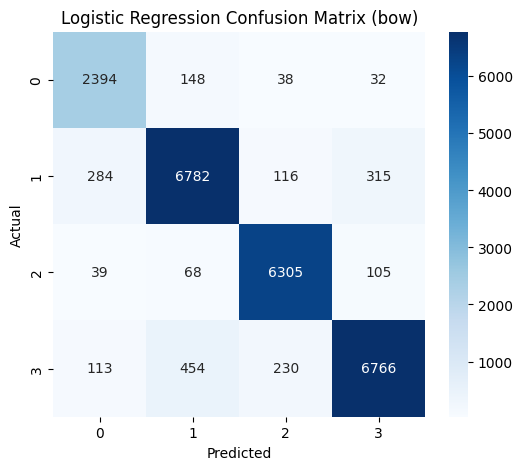

→ Training Decision Tree ...


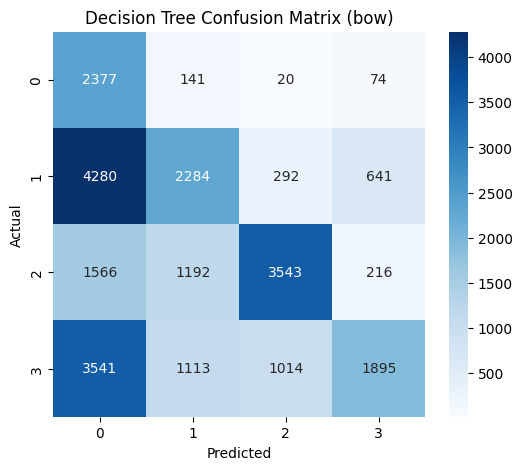

→ Training Random Forest ...


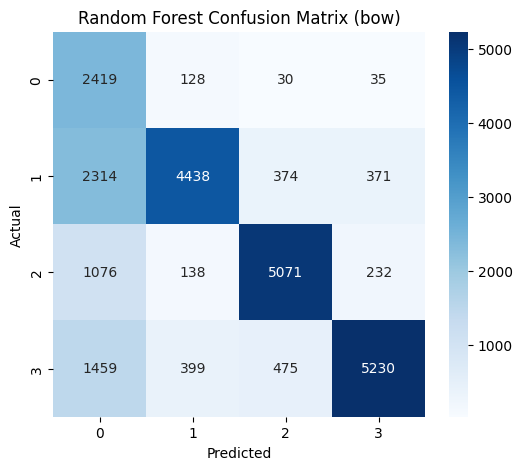

→ Training MultinomialNB ...


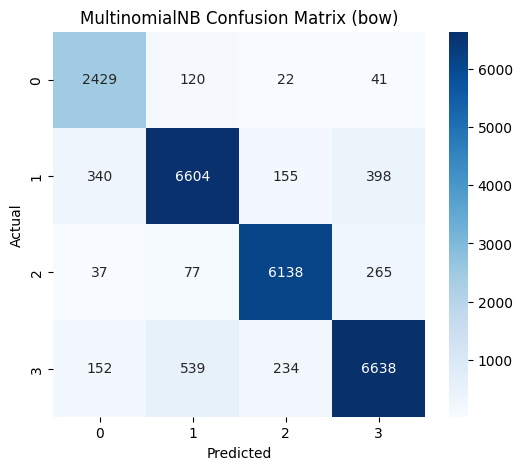


=== 🔹 Feature: tfidf ===
Loaded shapes: (96753, 10000) (24189, 10000)
→ Training Logistic Regression ...


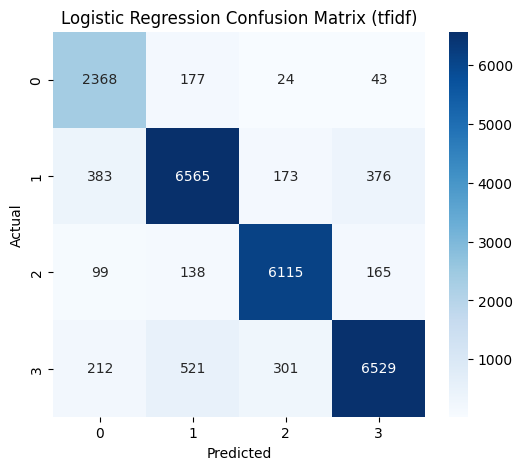

→ Training Decision Tree ...


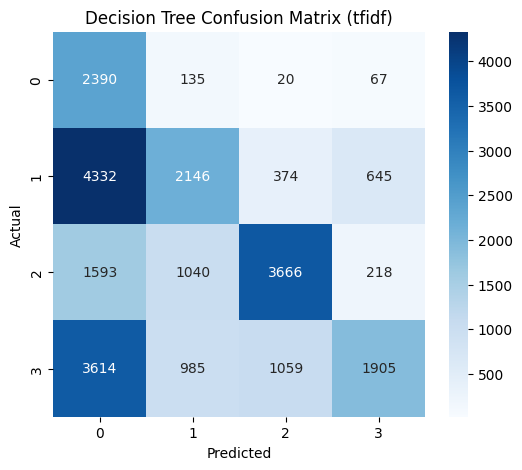

→ Training Random Forest ...


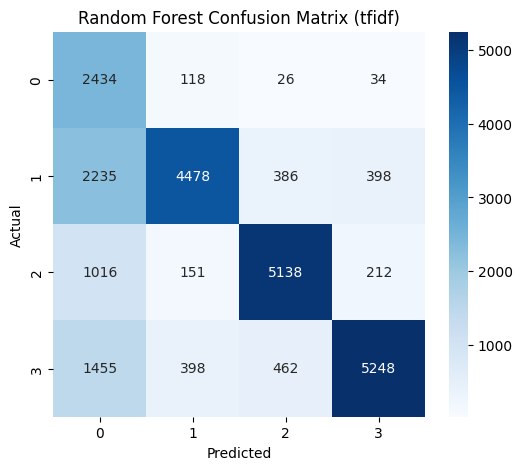

→ Training MultinomialNB ...


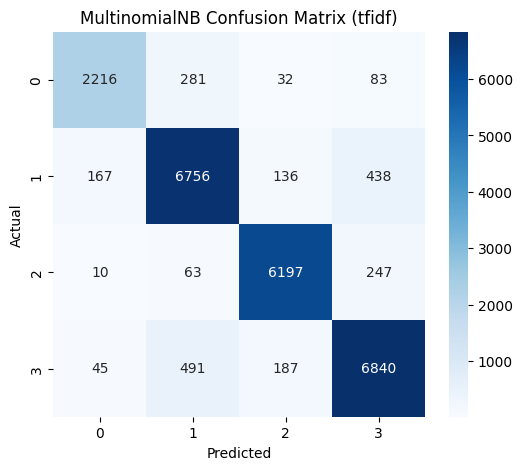


=== 🔹 Feature: ngram ===
Loaded shapes: (96753, 15000) (24189, 15000)
→ Training Logistic Regression ...


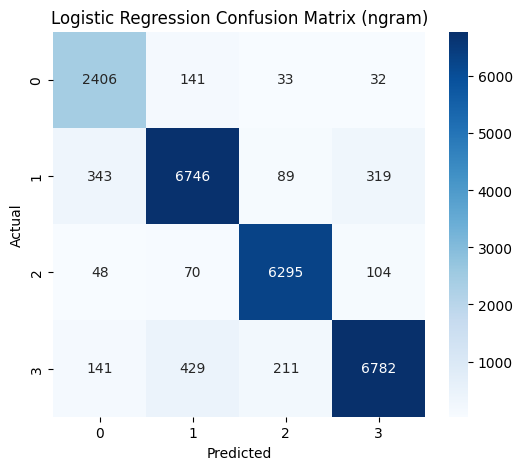

→ Training Decision Tree ...


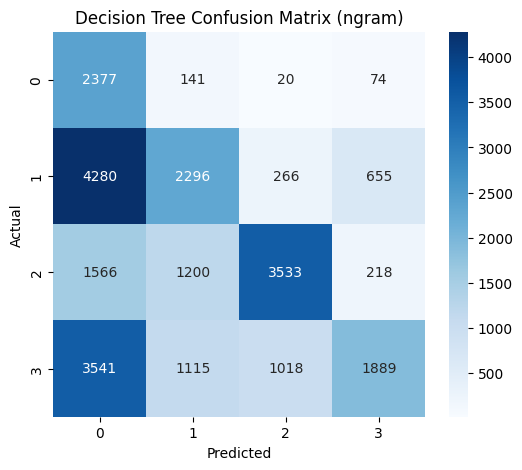

→ Training Random Forest ...


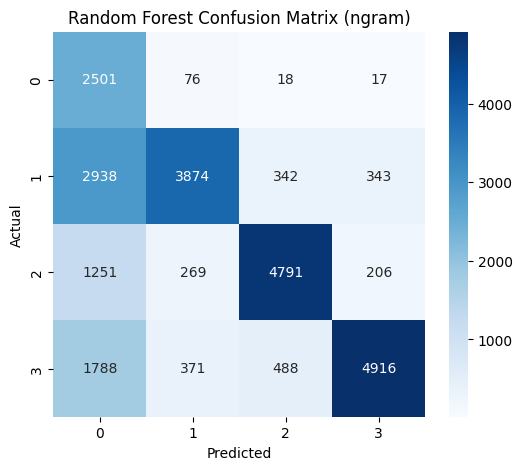

→ Training MultinomialNB ...


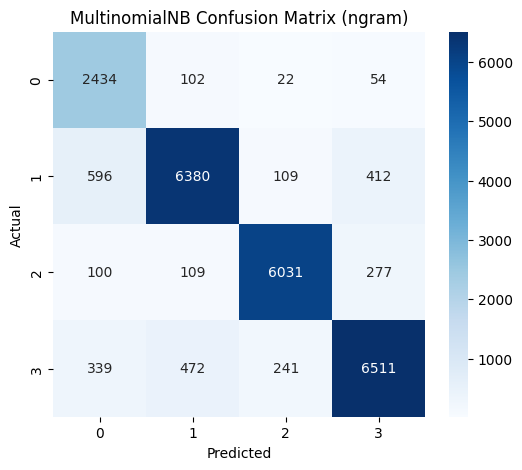


=== 🔹 Feature: glove ===
Loaded shapes: (96753, 100) (24189, 100)
→ Training Logistic Regression ...


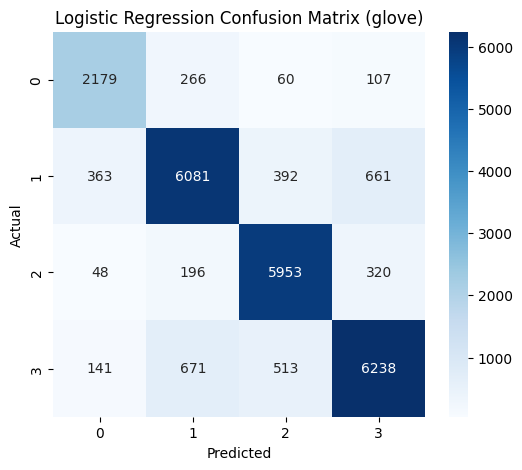

→ Training Decision Tree ...


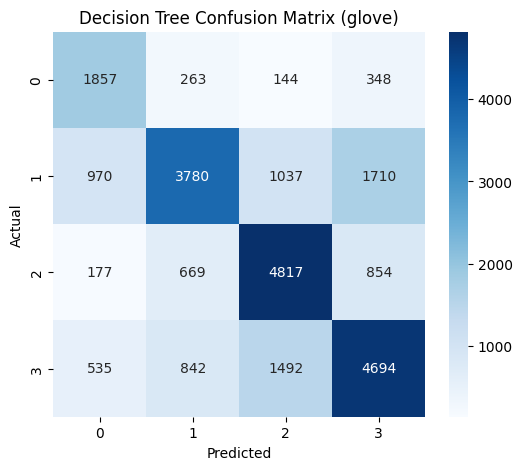

→ Training Random Forest ...


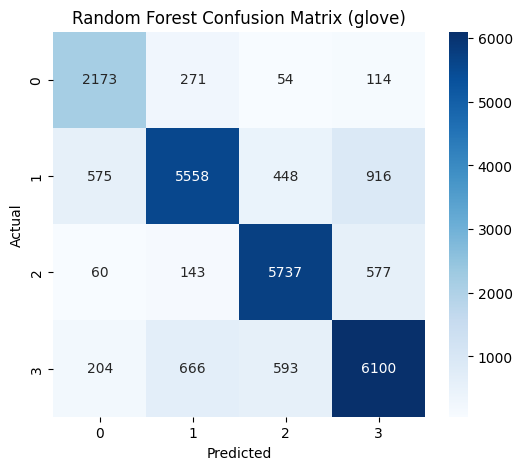

→ Training MultinomialNB ...
⚠️ Feature glove bị lỗi: Negative values in data passed to MultinomialNB (input X).

=== 🔹 Feature: distilbert ===
Loaded shapes: (96753, 768) (24189, 768)
→ Training Logistic Regression ...


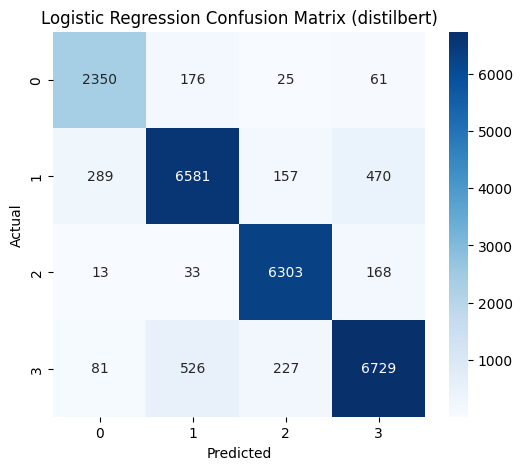

→ Training Decision Tree ...


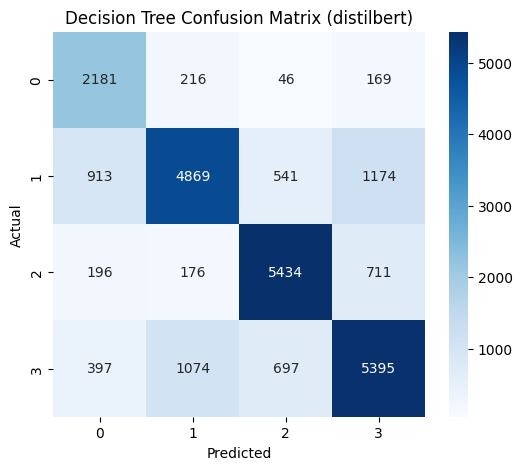

→ Training Random Forest ...


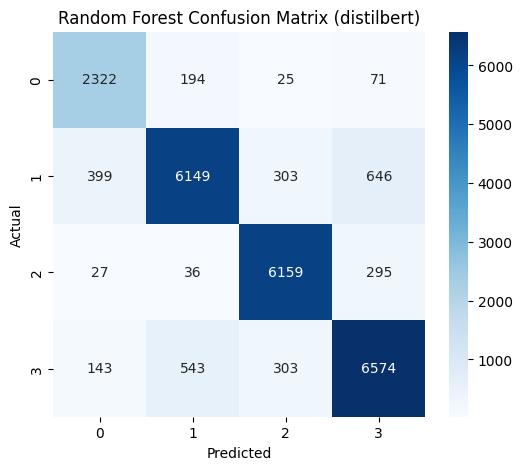

→ Training MultinomialNB ...
⚠️ Feature distilbert bị lỗi: Negative values in data passed to MultinomialNB (input X).


In [ ]:
feature_choices = ['bow', 'tfidf', 'ngram', 'glove', 'distilbert'] # Lấy từ tập ['bow', 'tfidf', 'ngram', 'glove', 'distilbert']

for feat in feature_choices:
    try:
        train_eval(feat)
    except Exception as e:
        print(f"⚠️ Feature {feat} bị lỗi: {e}")

## 4.6. Tổng hợp kết quả & chọn best model

- Hiển thị toàn bộ kết quả train/eval cho từng feature + model
- Tạo bảng **best model cho từng metric**
- Metrics có thể điều chỉnh (Accuracy, Precision, Recall, F1-score)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)
display(results_df.style.hide(axis="index"))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
best_summary = []
for metric in metrics:
    idx = results_df[metric].idxmax()
    best_row = results_df.loc[idx]
    best_summary.append({
        'Metric': metric,
        'Best Model': best_row['Model'],
        'Feature': best_row['Feature'],
        'Best Score': best_row[metric]
    })

display(pd.DataFrame(best_summary).style.hide(axis="index"))

Feature,Model,Accuracy,Precision,Recall,F1-score
bow,Logistic Regression,0.919716,0.920452,0.919716,0.919729
bow,Decision Tree,0.417504,0.577185,0.417504,0.433234
bow,Random Forest,0.709331,0.813772,0.709331,0.733884
bow,MultinomialNB,0.901608,0.902722,0.901608,0.901707
tfidf,Logistic Regression,0.892017,0.894557,0.892017,0.892430
tfidf,Decision Tree,0.417835,0.579141,0.417835,0.432530
tfidf,Random Forest,0.715118,0.815307,0.715118,0.738345
tfidf,MultinomialNB,0.909876,0.909915,0.909876,0.909768
ngram,Logistic Regression,0.918971,0.920397,0.918971,0.919187
ngram,Decision Tree,0.417338,0.576614,0.417338,0.433161


Metric,Best Model,Feature,Best Score
Accuracy,Logistic Regression,bow,0.919716
Precision,Logistic Regression,bow,0.920452
Recall,Logistic Regression,bow,0.919716
F1-score,Logistic Regression,bow,0.919729


# **5. End-to-End Deep Learning: LSTM**

Mục tiêu:
- Học trực tiếp từ văn bản (giữ nguyên case, giữ stopwords) để dự đoán `Subject`
- So sánh với các phương pháp ML + feature extraction (BoW, TF-IDF, n-gram, GloVe, Word2Vec, DistilBERT embeddings)
- Sử dụng LSTM với embedding layer train từ đầu
- Hỗ trợ **load pretrained model** nếu đã train trước

## 5.1. Chuẩn bị dữ liệu

- Load văn bản đã chuẩn bị (`X_train_v2.npy` / `X_test_v2.npy`)  
- Load nhãn đã encode (`y_train.npy`, `y_test.npy`)  
- Encode số lớp, hiển thị kích thước

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

FEATURE_DIR = "ml-asm-dna05/features/BTL2/"

# Load text DL-ready
X_train_text = np.load(FEATURE_DIR + "X_train_v2.npy", allow_pickle=True)
X_test_text  = np.load(FEATURE_DIR + "X_test_v2.npy", allow_pickle=True)

# Load nhãn đã encode sẵn
y_train_enc = np.load(FEATURE_DIR + "y_train.npy", allow_pickle=True)
y_test_enc  = np.load(FEATURE_DIR + "y_test.npy", allow_pickle=True)

num_classes = len(np.unique(y_train_enc))
print("Num classes:", num_classes)
print("Train size:", len(X_train_text), "Test size:", len(X_test_text))

Num classes: 4
Train size: 96753 Test size: 24189


## 5.2. Tokenizer & Dataset

- Tokenizer đơn giản: `text.split()`
- Build vocab từ train set, giữ `<pad>` và `<unk>`
- Dataset + collate_fn pad sequence
- DataLoader cho train/test

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# --------- Tokenizer đơn giản ---------
def tokenize(text):
    return text.split()

# --------- Build vocab thủ công ---------
tokenized = [tokenize(txt) for txt in X_train_text]
counter = Counter([tok for seq in tokenized for tok in seq])

vocab = {"<pad>": 0, "<unk>": 1}
for i, word in enumerate(counter.keys(), start=2):
    vocab[word] = i

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

# --------- Dataset ---------
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = [self.vocab.get(t, self.vocab["<unk>"]) for t in tokenize(self.texts[idx])]
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# --------- Collate function để pad batch ---------
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_pad = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return texts_pad, labels

# --------- DataLoader ---------
batch_size = 64
train_dataset = TextDataset(X_train_text, y_train_enc, vocab)
test_dataset  = TextDataset(X_test_text, y_test_enc, vocab)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


Vocab size: 56986


## 5.3. [Tuỳ chọn] Load pretrained

- Nếu đã train model trước đó, chỉ cần load weights và config
- Nếu chưa có, bỏ qua cell này và train từ đầu
- Thiết lập device CUDA/CPU

Tùy chọn: `LOAD_PRETRAINED = True` → load model, `LOAD_PRETRAINED = False` → bỏ qua.

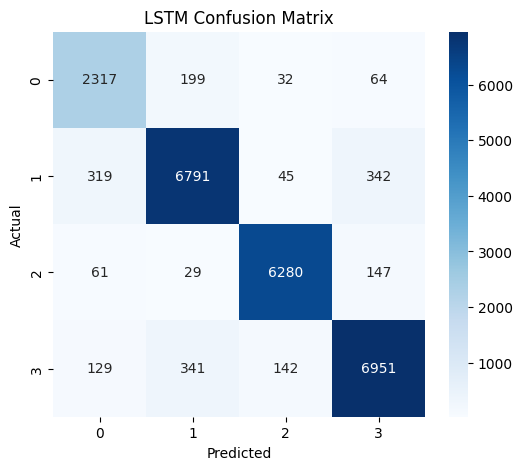

Test Results - Acc: 0.9235, Precision: 0.9245, Recall: 0.9235, F1: 0.9238


In [ ]:
LOAD_PRETRAINED = True  # True: load weights, False: bỏ qua
if LOAD_PRETRAINED:
  import torch
  import json
  import os
  from torch.utils.data import DataLoader
  from torch.nn.utils.rnn import pad_sequence


  # ---------------- Config ----------------
  save_dir = "ml-asm-dna05/features/BTL2/LSTM"

  # Load config
  with open(os.path.join(save_dir, "config.json"), "r") as f:
      config = json.load(f)

  embedding_dim = config["embedding_dim"]
  hidden_dim = config["hidden_dim"]
  vocab_size = config["vocab_size"]
  num_classes = config["num_classes"]

  # ---------------- Rebuild model ----------------
  import torch.nn as nn

  class LSTMClassifier(nn.Module):
      def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
          super().__init__()
          self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
          self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
          self.fc = nn.Linear(hidden_dim*2, num_classes)

      def forward(self, x):
          x = self.embedding(x)
          _, (h_n, _) = self.lstm(x)
          h_n = torch.cat((h_n[0], h_n[1]), dim=1)
          out = self.fc(h_n)
          return out

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)

  # Load trained weights
  model.load_state_dict(torch.load(os.path.join(save_dir, "model_lstm.pth"), map_location=device))
  model.eval()

  # ---------------- Prepare DataLoader ----------------
  batch_size = config["batch_size"]
  test_loader = DataLoader(test_dataset,
                          batch_size=batch_size, shuffle=False,
                          collate_fn=lambda batch: (
                              pad_sequence([x for x,_ in batch], batch_first=True, padding_value=0),
                              torch.stack([y for _,y in batch])
                          ))

  # ---------------- Evaluate on test set ----------------
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.metrics import confusion_matrix

  y_true, y_pred = [], []
  with torch.no_grad():
      for texts, labels in test_loader:
          texts, labels = texts.to(device), labels.to(device)
          outputs = model(texts)
          preds = torch.argmax(outputs, dim=1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(preds.cpu().numpy())

  # ---------------- Confusion Matrix ----------------
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("LSTM Confusion Matrix")
  plt.show()

  acc  = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
  rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
  f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

  print(f"Test Results - Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
else:
  print("⚠️ Huấn luyện lại mô hình và đánh giá !")

## 5.4. LSTM Model

- Bidirectional LSTM với embedding layer train từ đầu
- Linear layer cuối ra số lớp `num_classes`
- Cấu hình hyperparameter có thể thay đổi: `embedding_dim`, `hidden_dim`, `bidirectional`
- Hỗ trợ **load pretrained model** từ `model_lstm.pth` nếu đã train

In [ ]:
if not LOAD_PRETRAINED:
  import torch.nn as nn
  import torch.optim as optim

  class LSTMClassifier(nn.Module):
      def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
          super().__init__()
          self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
          self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
          self.fc = nn.Linear(hidden_dim*2, num_classes)

      def forward(self, x):
          x = self.embedding(x)
          _, (h_n, _) = self.lstm(x)
          h_n = torch.cat((h_n[0], h_n[1]), dim=1)  # bidirectional
          out = self.fc(h_n)
          return out

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_lstm = LSTMClassifier(vocab_size, embed_dim=128, hidden_dim=128, num_classes=num_classes).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
else:
  print("⚠️ Dùng mô hình pretrained, không huấn luyện lại !")

## 5.5. Train LSTM

In [ ]:
if not LOAD_PRETRAINED:
  # ============================================================
  # 5.4 Train & Evaluate LSTM (train full epochs, then test once)
  # ============================================================
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  from tqdm import tqdm
  import json
  import csv
  import os

  save_dir = "ml-asm-dna05/features/BTL2"
  os.makedirs(save_dir, exist_ok=True)

  # ---------------- Training / Evaluation functions ----------------
  def train_epoch(model, loader, criterion, optimizer, device):
      model.train()
      total_loss = 0
      loop = tqdm(loader, desc="Training", leave=False)
      for texts, labels in loop:
          texts, labels = texts.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(texts)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          loop.set_postfix(loss=loss.item())
      return total_loss / len(loader)

  def eval_model(model, loader, device):
      model.eval()
      y_true, y_pred = [], []
      with torch.no_grad():
          for texts, labels in loader:
              texts, labels = texts.to(device), labels.to(device)
              outputs = model(texts)
              preds = torch.argmax(outputs, dim=1)
              y_true.extend(labels.cpu().numpy())
              y_pred.extend(preds.cpu().numpy())
      acc  = accuracy_score(y_true, y_pred)
      prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
      rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
      f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)
      return acc, prec, rec, f1

  # ---------------- Training loop ----------------
  num_epochs = 8
  epoch_losses = []

  for epoch in range(num_epochs):
      loss = train_epoch(model_lstm, train_loader, criterion, optimizer, device)
      print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f}")
      epoch_losses.append({"epoch": epoch+1, "loss": loss})
else:
  print("⚠️ Dùng mô hình pretrained, không huấn luyện lại !")

## 5.6. Evaluate LSTM

In [ ]:
if not LOAD_PRETRAINED:
  # ---------------- Evaluate on test set (once after all epochs) ----------------
  acc, prec, rec, f1 = eval_model(model_lstm, test_loader, device)
  print(f"LSTM Test Results - Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

  # ---------------- Save model & optimizer ----------------
  torch.save(model_lstm.state_dict(), os.path.join(save_dir, "model_lstm.pth"))
  torch.save(optimizer.state_dict(), os.path.join(save_dir, "optimizer_lstm.pth"))

  # ---------------- Save metrics/logs ----------------
  with open(os.path.join(save_dir, "metrics.csv"), "w", newline="") as f:
      writer = csv.DictWriter(f, fieldnames=["epoch", "loss", "accuracy", "precision", "recall", "f1"])
      writer.writeheader()
      for row in epoch_losses:
          writer.writerow({
              "epoch": row["epoch"],
              "loss": row["loss"],
              "accuracy": "",  # chưa eval từng epoch
              "precision": "",
              "recall": "",
              "f1": ""
          })
      # Thêm kết quả test cuối cùng
      writer.writerow({
          "epoch": "test",
          "loss": "",
          "accuracy": acc,
          "precision": prec,
          "recall": rec,
          "f1": f1
      })

  # ---------------- Save config/hyperparameters ----------------
  config = {
      "embedding_dim": 128,
      "hidden_dim": 128,
      "bidirectional": True,
      "vocab_size": vocab_size,
      "num_classes": num_classes,
      "batch_size": 64,
      "learning_rate": 1e-3,
      "num_epochs": num_epochs
  }
  with open(os.path.join(save_dir, "config.json"), "w") as f:
      json.dump(config, f, indent=4)

  print("Training complete. Model, optimizer, config, and metrics saved in", save_dir)
else:
  print("⚠️ Dùng mô hình pretrained, không huấn luyện lại !")